In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import gpflow
import tensorflow as tf
from sklearn.metrics import r2_score


KeyboardInterrupt



In [ ]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [ ]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

### Load Data

In [4]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

In [5]:
dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_pftmean_amax_1985-2023.nc')

In [6]:
# drop crashers
ds_clean = ds.where(ds['crashed'] != 1, drop=True)
ix = np.where(ds.crashed==1)[0]
params_clean = params.drop(ix-1)

In [7]:
lai = ds_clean.TLAI_pft_amax.sel(year=slice(2003,2015)).mean(dim='year').compute()

In [8]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][1:16]

/glade/derecho/scratch/linnia/tmp/ipykernel_49937/2024365891.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname


### Train emulators

In [9]:
# define kernels
num_params = 56
kernel_noise = gpflow.kernels.White(variance=1e-3)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,56))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,56))
kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

kernel_dict = {
    0:kernel_linear + kernel_noise,
    1:kernel_RBF,
    2:kernel_RBF + kernel_linear + kernel_noise,
    3:kernel_RBF + kernel_linear + kernel_noise + kernel_bias,
    4:kernel_poly,
    5:kernel_poly + kernel_linear + kernel_noise,
    6:kernel_RBF + kernel_linear + kernel_noise + kernel_bias + kernel_poly,
    7:kernel_matern32,
    8:kernel_matern32+kernel_linear+kernel_noise,
    9:kernel_matern32*kernel_linear+kernel_noise,
    10:kernel_linear*kernel_RBF+kernel_matern32 + kernel_noise
}

2025-02-03 17:08:27.475735: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft1/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft1/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft2/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft2/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft3/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft3/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft4/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft4/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft5/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft5/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft6/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft6/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft7/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft7/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft8/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft8/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft9/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft9/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft10/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft10/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft11/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft11/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft12/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft12/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft13/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft13/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft14/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft14/assets


saving
INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft15/assets


INFO:tensorflow:Assets written to: ./emulators_pftlai_amax_lhc/pft15/assets


ValueError: Input contains NaN.

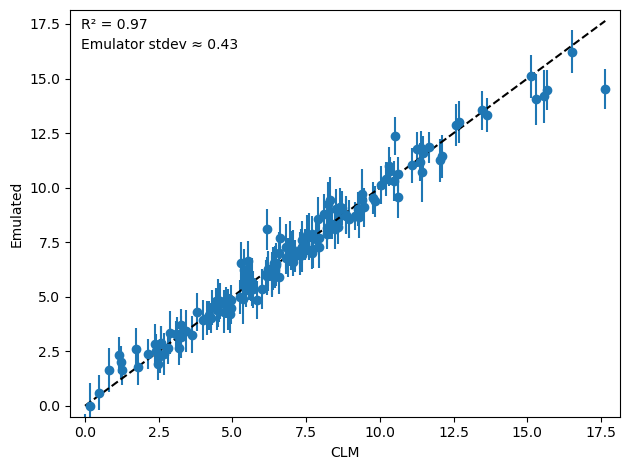

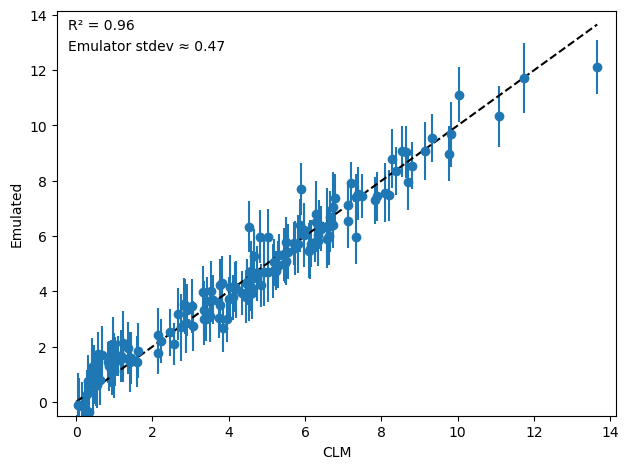

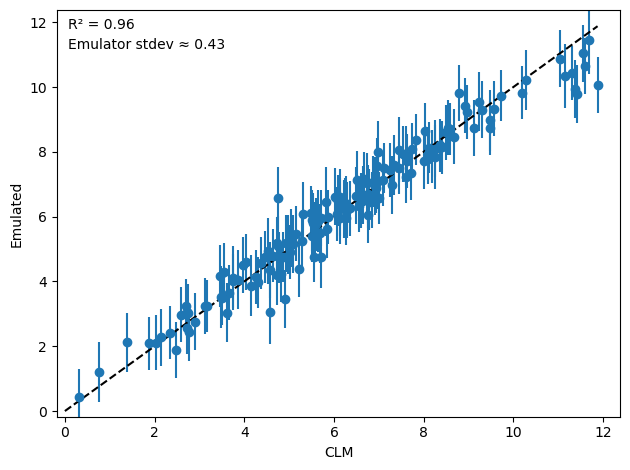

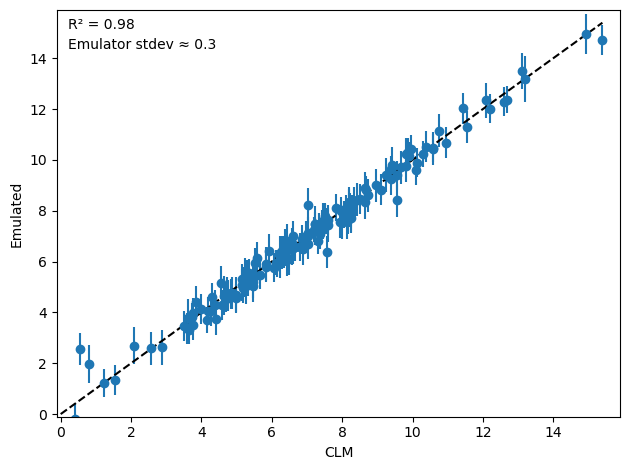

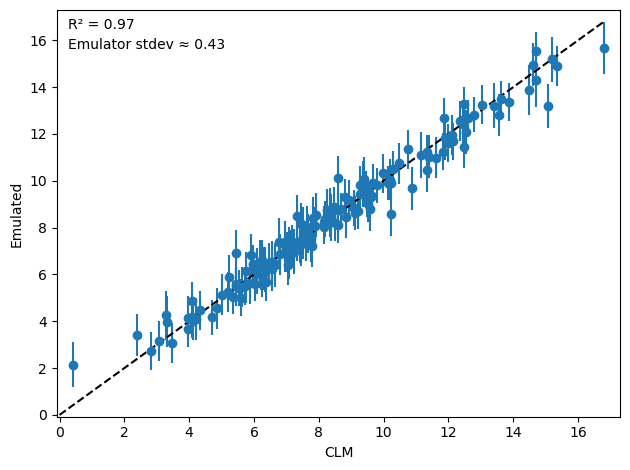

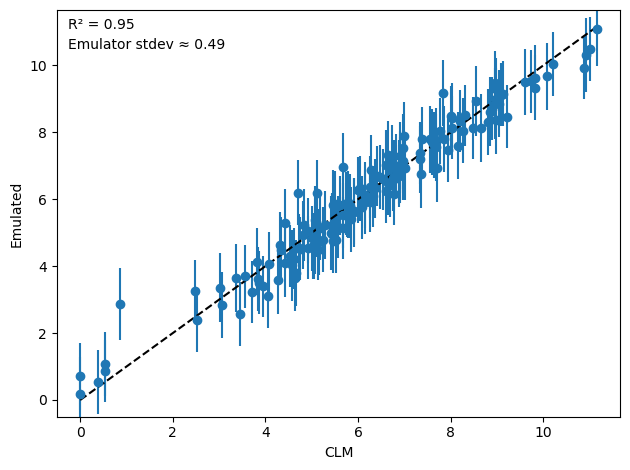

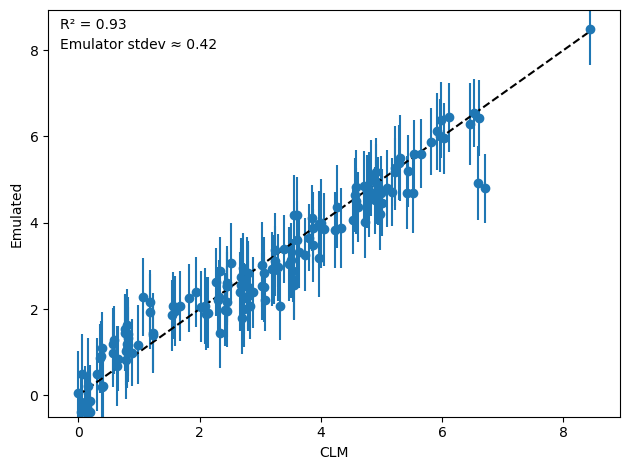

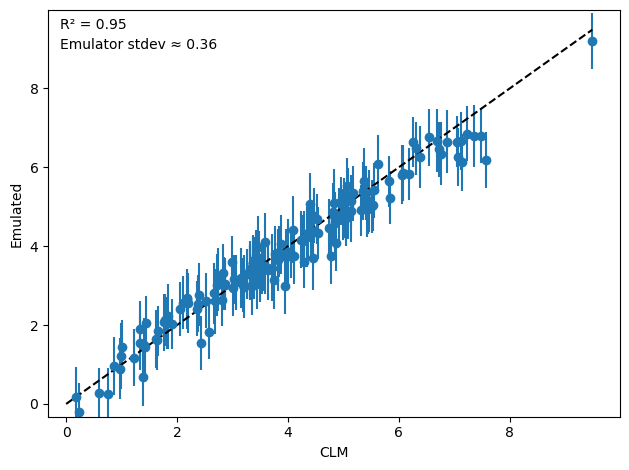

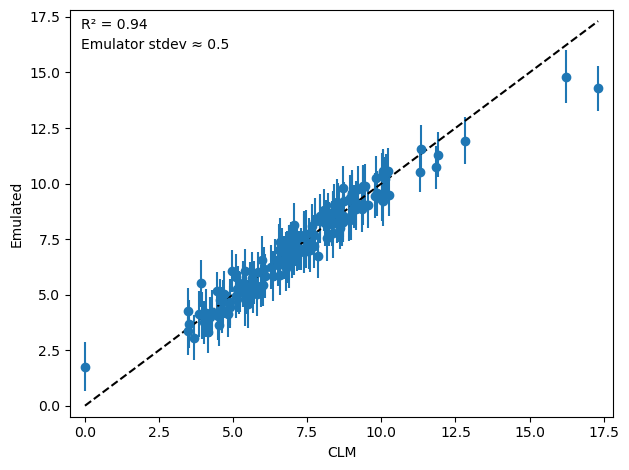

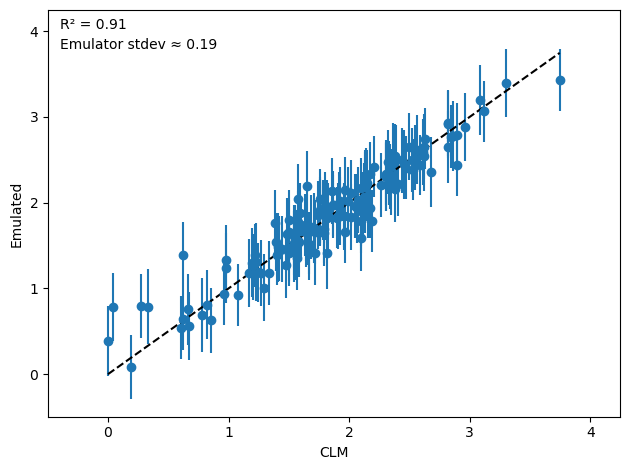

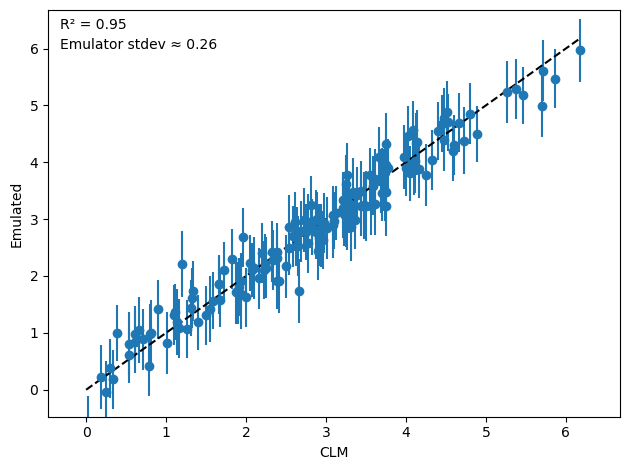

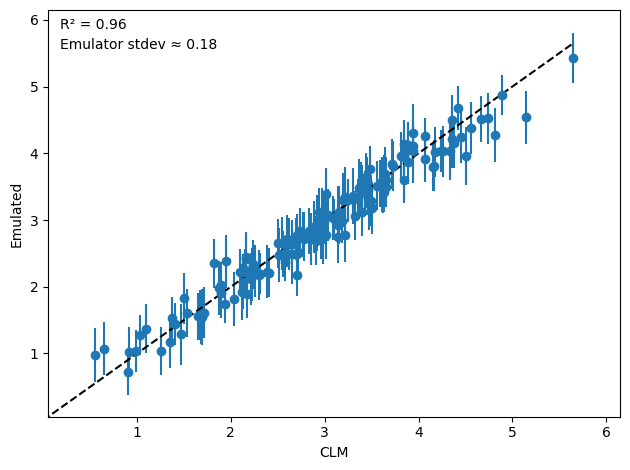

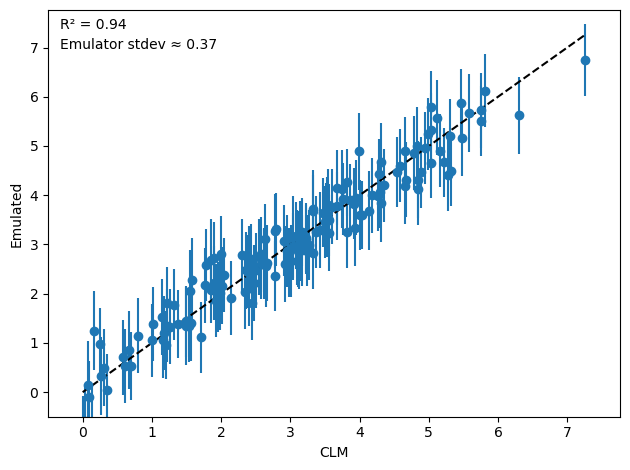

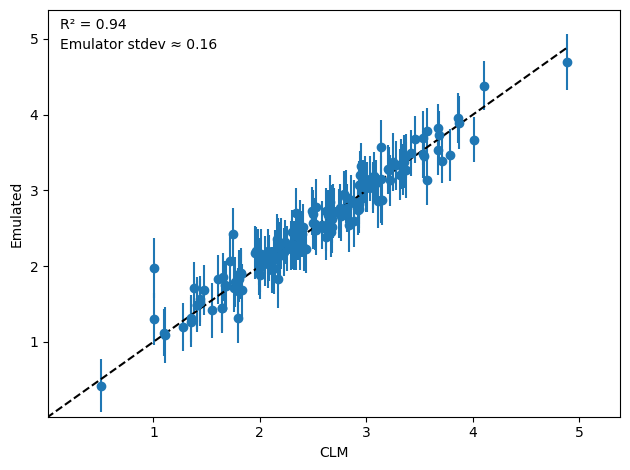

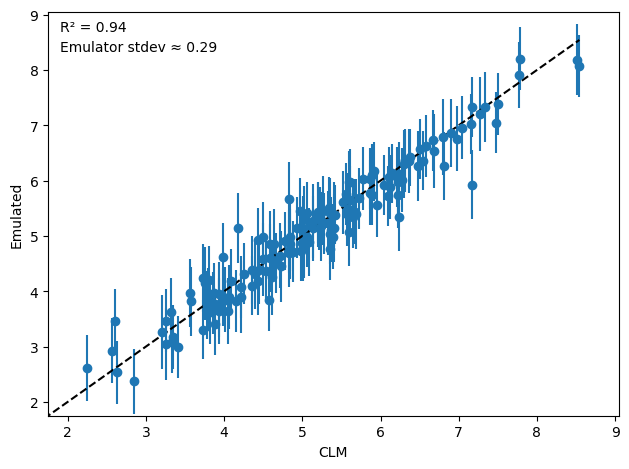

In [10]:
# Train and save emulators
data = lai
ntest = 150

R2_score = np.empty((18))*np.NaN
stdev = np.empty((18))*np.NaN
for p,pft in enumerate(ds_clean.pft.values[1:].astype(int)):
    savedir = str('./emulators_pftlai_amax_lhc/pft'+str(pft)) # where to save emulator
    outfile = './figs/emulator_validation_laimax_pft'+str(pft)+'.png' # validation figure
    
    X = params_clean
    Y = data.sel(pft=pft)[1:]
    X_test, X_train = X.values[:ntest,:], X.values[ntest:,:]
    y_test, y_train = Y[:ntest].values.reshape(-1,1), Y[ntest:].values.reshape(-1,1)

    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    R2_score[p], stdev[p] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile,savedir)

In [ ]:
row_labels = ['LAI']
col_labels = pfts[:15]
df = pd.DataFrame(R2_score[:15], index=col_labels, columns=row_labels)

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size
c = ax.imshow(df.values, cmap='pink', origin='upper', aspect='auto',vmin=0.75,vmax=1)

# Add colorbar
cbar = plt.colorbar(c, ax=ax, orientation="vertical")
cbar.set_label("Coef. of Determination", fontsize=16)

# Set row and column labels
ax.set_xticks(np.arange(len(df.columns)))  # Set column positions
ax.set_yticks(np.arange(len(df.index)))    # Set row positions

ax.set_xticklabels(df.columns, fontsize=16, rotation=45, ha="right")
ax.set_yticklabels(df.index, fontsize=16)

# Add axis labels and title
ax.set_title("Emulator Validation (R2)", fontsize=18, fontweight="bold")
#ax.set_xlabel("PFTs", fontsize=16)
plt.tight_layout()
plt.savefig('./figs/emulator_validation_pftlaimax_R2heatmap.png')

In [ ]:
row_labels = ['LAI']
col_labels = pfts[:15]
df = pd.DataFrame(stdev[:15], index=col_labels, columns=row_labels)

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size
c = ax.imshow(df.values, cmap='pink', origin='upper', aspect='auto',vmin=0,vmax=1)

# Add colorbar
cbar = plt.colorbar(c, ax=ax, orientation="vertical")
cbar.set_label("Coef. of Determination", fontsize=16)

# Set row and column labels
ax.set_xticks(np.arange(len(df.columns)))  # Set column positions
ax.set_yticks(np.arange(len(df.index)))    # Set row positions

ax.set_xticklabels(df.columns, fontsize=16, rotation=45, ha="right")
ax.set_yticklabels(df.index, fontsize=16)

# Add axis labels and title
ax.set_title("Emulator Validation (R2)", fontsize=18, fontweight="bold")
#ax.set_xlabel("PFTs", fontsize=16)
plt.tight_layout()
plt.savefig('./figs/emulator_validation_pftlaimax_stdev_heatmap.png')